In [1]:
import os
import json
from pathlib import Path
import random
import torch
from datasets import load_dataset
#from transform_tokenize import transform_and_tokenize
from transformers import DonutProcessor
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

c:\Users\AI Lipik\Desktop\m\lipik-llama\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
new_special_tokens = [] # New tokens to add to the tokenizer
task_start_token ="<s>"
eos_token = "</s>"

In [3]:
# Define paths for our image and json files
#base_path = Path("..\data")
base_path = Path("racuni")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

Resolving data files: 100%|██████████| 127/127 [00:00<00:00, 126137.01it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating train split: 126 examples [00:00, 6627.73 examples/s]

Dataset has 126 images
Dataset features are: dict_keys(['image', 'text'])
Random sample is 64
OCR text is {"Store name": "SPAR HRVATSKA d.o.o.", "Store address": "ANDRIJE HEBRANGA 18,34550 PAKRAC", "Unit 1 name": "INST .KAVA SPAR 3U1 180 g", "Unit 2 name": "\u0161UNKA PREMIUM KARLOVA\u010dKA", "Unit 1 Price": "1.45", "Unit 2 Price": "0.85", "Total Amount": "3.63"}


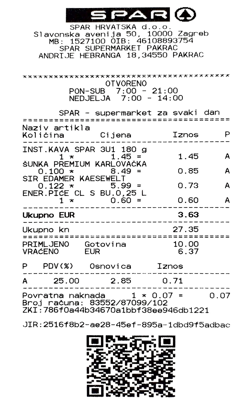

In [113]:
# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
# Sample should be similar to: OCR text is {"Store name": "SPAR HRVATSKA d.o.o.", "Store address": "ANDRIJE HEBRANGA 18,34550 PAKRAC", "Unit 1 name": "INST .KAVA SPAR 3U1 180 g", "Unit 2 name": "\u0161UNKA PREMIUM KARLOVA\u010dKA", "Unit 1 Price": "1.45", "Unit 2 Price": "0.85", "Total Amount": "3.63"}


In [114]:
# json2token metoda od tvoraca Donut modela (Clova AI)

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj



In [115]:
# Moramo procesirati cijeli dataset sa našom metodom, odnosno pridružiti image fileu labele i vrijednosti tih labela

def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Map: 100%|██████████| 126/126 [00:46<00:00,  2.73 examples/s]

Sample: <s><s_Unit 2 name>JOGURT TEK ACTIVE ZO</s_Unit 2 name><s_Unit 2 Price>0,25</s_Unit 2 Price><s_Unit 1 name>MLIJ TR 2,8% 1/2L V</s_Unit 1 name><s_Unit 1 Price>0,99</s_Unit 1 Price><s_Total Amount>4,62</s_Total Amount><s_Store name>KONZUM plus d.o.o.</s_Store name><s_Store address>Zagreb, Ulica Marijana Čavića 1A</s_Store address></s>
New special tokens: ['<s_Unit 1 name>', '</s_Unit 1 name>', '<s_Unit 1 Price>', '</s_Unit 1 Price>', '<s_Total Amount>', '</s_Total Amount>', '<s_Store name>', '</s_Store name>', '<s_Store address>', '</s_Store address>', '<s_Unit 2 name>', '</s_Unit 2 name>', '<s_Unit 2 Price>', '</s_Unit 2 Price>', '<s>', '</s>']


In [116]:
# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})
processor.feature_extractor.size = [720, 960] # should be (width, height), try 720, 960 if fails
processor.feature_extractor.do_align_long_axis = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\AI Lipik\Desktop\m\lipik-llama\env\Lib\site-packages\transformers\models\donut\processing_donut.py:189: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [118]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}


In [119]:
# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map: 100%|██████████| 126/126 [00:22<00:00,  5.56 examples/s]


In [120]:
# ovo si isto naprimjer možeš modificirati za novi dataset, odnosno moraš

processed_dataset.save_to_disk("processed__lipik_dataset")
processor.save_pretrained("processor_lipik")

processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

Saving the dataset (3/3 shards): 100%|██████████| 126/126 [00:01<00:00, 87.05 examples/s]

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 113
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 13
    })
})


In [121]:
# Load our model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("oxioxi/donut-base-sroie")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

New embedding size: Embedding(57539, 1024)


Ovu ćeliju ispod ćemo morati prilagoditi ako želimo raditi dodatan finetune našeg finetune modela

In [122]:
# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(device)
# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie-v1.5"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    
)

trainer.train()

cuda


 58%|█████▊    | 100/171 [09:18<06:29,  5.49s/it]

{'loss': 4.8273, 'learning_rate': 9.12280701754386e-06, 'epoch': 1.75}


100%|██████████| 171/171 [2:35:24<00:00, 54.53s/it]   


{'train_runtime': 9324.377, 'train_samples_per_second': 0.036, 'train_steps_per_second': 0.018, 'train_loss': 3.4826434843721445, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=3.4826434843721445, metrics={'train_runtime': 9324.377, 'train_samples_per_second': 0.036, 'train_steps_per_second': 0.018, 'train_loss': 3.4826434843721445, 'epoch': 3.0})

In [123]:

# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

sentencepiece.bpe.model: 100%|██████████| 1.30M/1.30M [00:01<00:00, 948kB/s] 


'https://huggingface.co/oxioxi/donut-base-sroie-v1.5/tree/main/'

Eval part

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reference:
 {'Unit 2 name': 'JOGURT TEK ACTIVE ZO', 'Unit 2 Price': '0,25', 'Unit 1 name': 'MLIJ TR 2,8% 1/2L V', 'Unit 1 Price': '0,99', 'Total Amount': '4,62', 'Store name': 'KONZUM plus d.o.o.', 'Store address': 'Zagreb, Ulica Marijana Čavića 1A'}
Prediction:
 {'Unit 1 Price': '0,99', 'Total Amount': '4,62', 'Store name': 'KONZUM plus d.o.o.', 'Store address': 'Rijeka, Riva 16'}


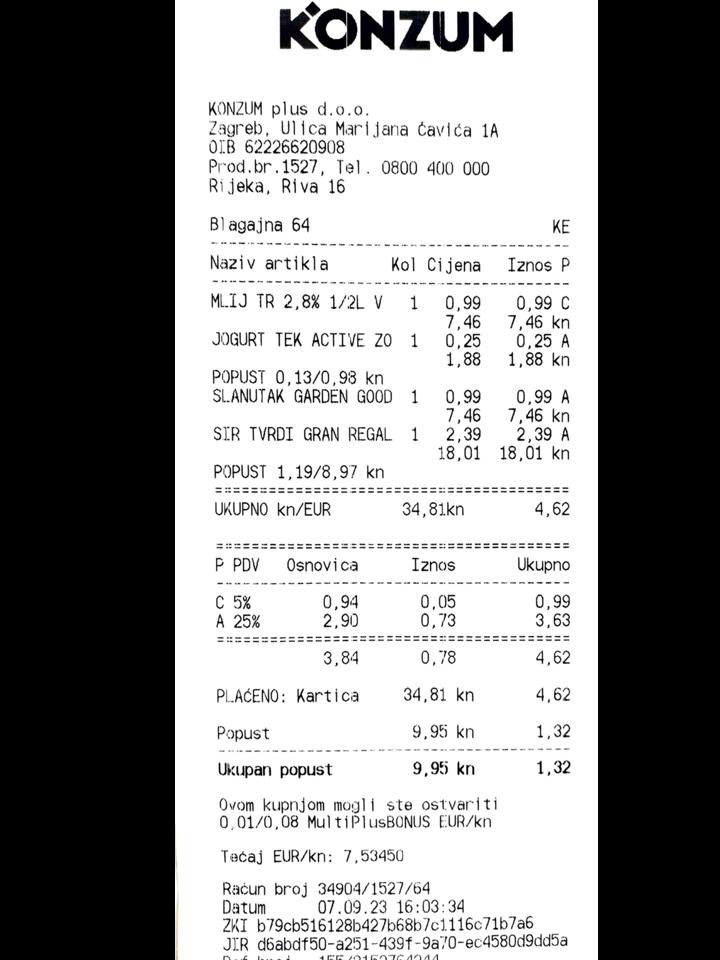

In [126]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("oxioxi/donut-base-sroie-v1.5")
model = VisionEncoderDecoderModel.from_pretrained("oxioxi/donut-base-sroie-v1.5")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 12)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

# Debugirati, ovo bi trebalo displayati sliku kao gore na početku

#print(test_sample.keys())
#print(np.array(test_sample["pixel_values"]))

pixel_values = np.squeeze(test_sample["pixel_values"])
pixel_values = (pixel_values + 1) / 2


to_pil_image(pixel_values)
#to_pil_image(pixel_values)
# Rescale values between 0-1
#pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))
#to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


In [127]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")
# Accuracy: 75.0%


  0%|          | 0/13 [00:00<?, ?it/s]c:\Users\AI Lipik\Desktop\m\lipik-llama\env\Lib\site-packages\transformers\generation\configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 13/13 [15:28<00:00, 71.39s/it]

Accuracy: 0.0%
